In [1]:
import tensorflow as tf
tf.__version__

'2.13.0'

In [2]:
# Get helper function
import os
if os.path.exists('helper_functions.py'):
  print('[INFO] helper function is already exists :-).')

else:
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-12 00:52:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-12 00:52:42 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# FoodVision101 Dataset
import tensorflow_datasets as tfds

dataset_list = tfds.list_builders()
target_dataset='food101'
print(f'{target_dataset} is exist in TensorFlow Dataset: {target_dataset in dataset_list}')

food101 is exist in TensorFlow Dataset: True


In [4]:
from tensorflow.python.distribute.tpu_strategy import tpu_replicated_variable
# load the dataset
(train_data, validation_data), ds_info  = tfds.load(name= 'food101',
                                           split=['train', 'validation'],
                                           shuffle_files=True,
                                           as_supervised=True,
                                           with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete0OC9TQ/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete0OC9TQ/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [6]:
len(train_data), len(validation_data)

(75750, 25250)

In [7]:
# import helper functions from helper_functions.py
from helper_functions import plot_loss_curves, create_tensorboard_callback, compare_historys

In [8]:
# getting class names
class_names = ds_info.features['label'].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [9]:
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
for image, label in train_one_sample:
  print(image.shape)
  print(image.dtype)
  print(label)
  print(label.dtype)
  print(class_names[label])

(512, 288, 3)
<dtype: 'uint8'>
tf.Tensor(93, shape=(), dtype=int64)
<dtype: 'int64'>
steak


Text(0.5, 1.0, 'steak')

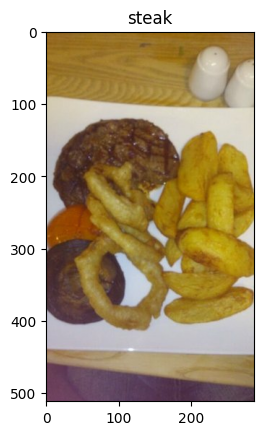

In [11]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label])

In [12]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

In [13]:
# Create a method to preprocess the dataset.
def data_preprocessing(image, label, shape=224):
  '''
  Convert datatype uint8->float32,
  Change image shape.
  '''
  image = tf.image.resize(image, [shape, shape])
  return tf.cast(image, dtype=tf.float32), label

In [14]:
pre_img, label = data_preprocessing(image, label)
pre_img.dtype, pre_img.ndim

(tf.float32, 3)

In [15]:
pre_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[147.30612 , 102.30612 ,  35.30612 ],
        [147.27551 , 102.27551 ,  35.27551 ],
        [148.61224 , 103.61224 ,  36.612244],
        ...,
        [145.61224 , 110.61225 ,  52.612247],
        [145.35715 , 110.35714 ,  52.357143],
        [145.35715 , 110.35714 ,  52.357143]],

       [[142.34694 ,  97.34694 ,  30.34694 ],
        [144.85715 ,  99.85714 ,  32.42857 ],
        [146.      , 101.      ,  33.      ],
        ...,
        [144.14285 , 109.14285 ,  53.142857],
        [144.14285 , 109.14285 ,  53.142857],
        [143.2857  , 108.285706,  52.28571 ]],

       [[147.54082 , 102.54082 ,  34.540817],
        [147.60204 , 102.60204 ,  34.60204 ],
        [148.08163 , 103.081635,  35.08163 ],
        ...,
        [141.78572 , 106.57144 ,  53.000008],
        [141.07143 , 105.85715 ,  52.285713],
        [141.07143 , 105.85715 ,  52.285713]],

       ...,

       [[111.367355,  67.367355,  94.367355],
        [114.

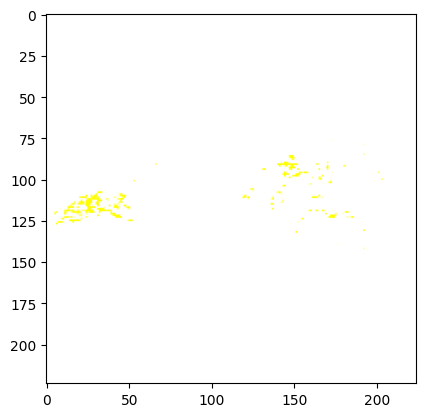

In [16]:
plt.imshow(pre_img) # Not display properly bcz of casting

Text(0.5, 1.0, 'steak')

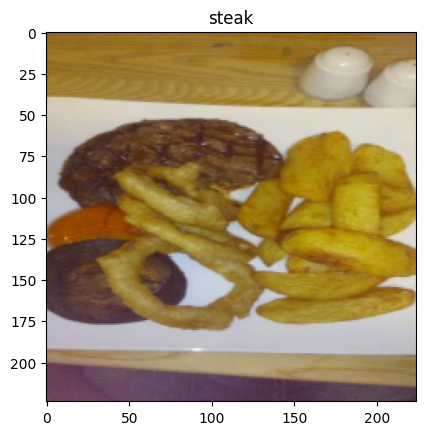

In [17]:
plt.imshow(pre_img/255.)
plt.title(class_names[label])

In [18]:
validation_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [19]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [20]:
# Batch and Prepare Dataset
# ** should run once **
#map data_preprocess
train_data = train_data.map(map_func=data_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
#shuffle data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# map preprocessing on test data
validation_data = validation_data.map(map_func=data_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
#turn validation_data into batches and prefetch it.
validation_data = validation_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
train_data, validation_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [22]:
# Create Model checkpoint callback to save model's progress
checkpoint_path = 'model_checkpoints/cp.ckpt'

model_checkpoints_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                                save_best_only=True,
                                                                save_weights_only=True,
                                                                save_freq='epoch',
                                                                monitor='val_accuracy')

In [23]:
# Turn on mix_precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy='mixed_float16')

In [24]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [25]:
# Build feature extraction model
from tensorflow.keras import layers

input_shape =(224, 224, 3)
# Create base_model
base_model_0 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_0.trainable = False

# Create Functional Model
inputs = layers.Input(shape=input_shape, name='input_layer')
# We don't need to work with rescale layer bcz of EfficientNetBx model.
x = base_model_0(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
outputs = layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
model_0 = tf.keras.Model(inputs, outputs, name='model_0')


# Compile the model
model_0.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step


In [26]:
model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (505.39 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [28]:
for layer in model_0.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)


input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "mixed_float16">


In [30]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model_0.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [31]:
# Fit the model
model_0_history = model_0.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=validation_data,
                              validation_steps=len(validation_data),
                              callbacks=[model_checkpoints_callback])

Epoch 1/5
2368/2368 [==============================] - 234s 91ms/step - loss: 1.7176 - accuracy: 0.5833 - val_loss: 1.1339 - val_accuracy: 0.7004
Epoch 2/5
2368/2368 [==============================] - 247s 103ms/step - loss: 1.1999 - accuracy: 0.6879 - val_loss: 1.0334 - val_accuracy: 0.7205
Epoch 3/5
2368/2368 [==============================] - 219s 91ms/step - loss: 1.0534 - accuracy: 0.7248 - val_loss: 0.9956 - val_accuracy: 0.7310
Epoch 4/5
2368/2368 [==============================] - 212s 88ms/step - loss: 0.9589 - accuracy: 0.7471 - val_loss: 0.9867 - val_accuracy: 0.7302
Epoch 5/5
2368/2368 [==============================] - 213s 89ms/step - loss: 0.8881 - accuracy: 0.7644 - val_loss: 0.9811 - val_accuracy: 0.7313


<Axes: >

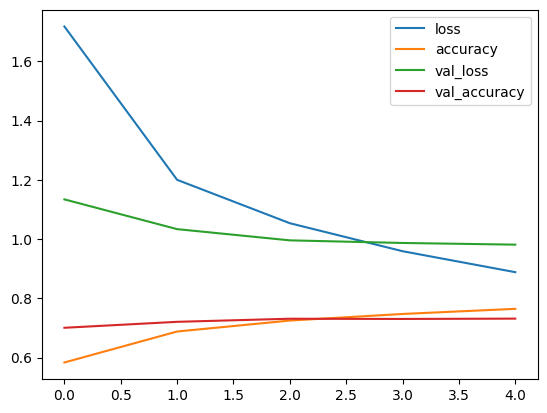

In [33]:
import pandas as pd
pd.DataFrame(model_0_history.history).plot()

In [34]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")


In [36]:
for layer in data_augmentation.layers:
  print(layer.name, layer.dtype, layer.dtype_policy)

random_flip float32 <Policy "mixed_float16">
random_rotation float32 <Policy "mixed_float16">
random_zoom float32 <Policy "mixed_float16">
random_height float32 <Policy "mixed_float16">
random_width float32 <Policy "mixed_float16">


In [37]:
# Build feature extraction model
from tensorflow.keras import layers

input_shape =(224, 224, 3)
# Create base_model_1
base_model_1 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_1.trainable = False

# Create Functional Model
inputs = layers.Input(shape=input_shape, name='input_layer')
# We don't need to work with rescale layer bcz of EfficientNetBx model.
x = data_augmentation(inputs)
x = base_model_0(x, training=False)
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
outputs = layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_0')


# Compile the model
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [38]:
for layer in model_1.layers:
  print(layer.name, layer.dtype, layer.dtype_policy)

input_layer float32 <Policy "float32">
data_augmentation float32 <Policy "mixed_float16">
efficientnetb0 float32 <Policy "mixed_float16">
pooling_layer float32 <Policy "mixed_float16">
output_layer float32 <Policy "mixed_float16">


In [39]:
# Fit the model
model_1_history = model_1.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=validation_data,
                              validation_steps=len(validation_data),
                              callbacks=[model_checkpoints_callback])

Epoch 1/5
2368/2368 [==============================] - 515s 212ms/step - loss: 2.0858 - accuracy: 0.4965 - val_loss: 1.3111 - val_accuracy: 0.6483
Epoch 2/5
2368/2368 [==============================] - 348s 146ms/step - loss: 1.5950 - accuracy: 0.5933 - val_loss: 1.1969 - val_accuracy: 0.6762
Epoch 3/5
2368/2368 [==============================] - 322s 135ms/step - loss: 1.4753 - accuracy: 0.6206 - val_loss: 1.1579 - val_accuracy: 0.6859
Epoch 4/5
2368/2368 [==============================] - 325s 136ms/step - loss: 1.3998 - accuracy: 0.6372 - val_loss: 1.1283 - val_accuracy: 0.6924
Epoch 5/5
2368/2368 [==============================] - 268s 112ms/step - loss: 1.3523 - accuracy: 0.6469 - val_loss: 1.1233 - val_accuracy: 0.6926


<Axes: >

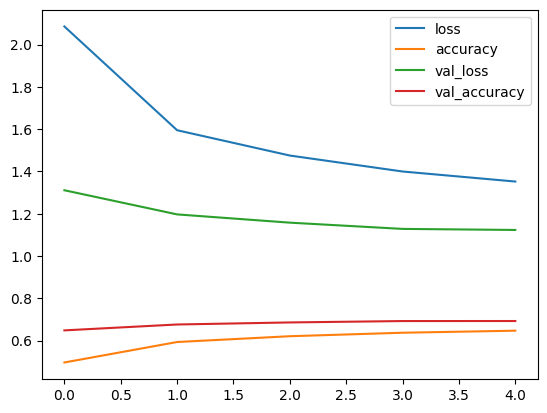

In [40]:
pd.DataFrame(model_1_history.history).plot()

In [41]:
model_1.save('food_vision101.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
